In [1]:
# Specify CUDA device
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

from jax.config import config
config.update("jax_enable_x64", True)

# Check we're running on GPU
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

from jax import jit, grad 
import jax.numpy as jnp 
import numpy as np 

from matplotlib.image import pil_to_array
from PIL import Image

import s2fft 
import s2wav 
from scatcovjax.Scattering_lib import scat_cov_axi

2023-03-01 16:17:52.268043: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


cpu


In [2]:
sampling = "mw"
multiresolution = True
reality = True
L = 128
N = 1
J_min = 0
np.random.seed(0)

In [3]:
# Planet image
import pyssht as ssht
grayscale_pil_image = Image.open('../texture_maps/venus.jpg').convert("L")
I = pil_to_array(grayscale_pil_image).astype(np.float64)
I = np.ascontiguousarray(I[:,:-1])
L_temp = I.shape[0]
Ilm = ssht.forward(I, L_temp, Reality=reality)
Ilm = Ilm[:L**2]
I = ssht.inverse(Ilm, L, Reality=reality)
I -= np.nanmean(I)

In [4]:
filters = s2wav.filter_factory.filters.filters_directional_vectorised(L, N, J_min)
Ilm = s2fft.forward_jax(I, L, reality=reality)

In [5]:
mean, var, S1, P00, C01 = scat_cov_axi(Ilm[:,L-1:], L, N, J_min, sampling, reality, multiresolution, filters=filters)
# mean, var, S1, P00, C01, C11 = scat_cov_axi(Ilm, L, N, J_min, sampling, reality, multiresolution, filters=filters)

In [8]:
def func(flm):
    mean_new, var_new, S1_new, P00_new, C01_new = scat_cov_axi(flm, L, N, J_min, sampling, reality, multiresolution, normalisation=P00, filters=filters)

    # Control for mean + var
    loss = jnp.abs(mean-mean_new)**2
    loss += jnp.abs(var-var_new)**2
    
    # Add S1 loss
    loss += jnp.sum(jnp.abs(S1-S1_new)**2)

    # Add P00 loss
    loss += jnp.sum(jnp.abs(P00-P00_new)**2)

    # Add C01 loss
    loss += jnp.sum(jnp.abs(C01-C01_new)**2)
    return loss

grad_func = jit(grad(func))
f = np.random.randn(L,2*L-1).astype(np.float64)
flm = s2fft.forward_jax(f, L, reality=reality)
flm = flm[:,L-1:] if reality else flm

flm_start = jnp.copy(flm)
loss_0 = func(flm_start)

In [14]:
iterations = 1000
momentum = 0.1
for i in range(iterations):
    flm -= momentum*np.conj(grad_func(flm))
    if i % 10 == 0: 
        print(f"Iteration {i}: Loss/Loss-0 = {func(flm)}/{loss_0}, Momentum = {momentum}")

Iteration 0: Loss/Loss-0 = 0.7740256967074524/118.93909289177772, Momentum = 0.1
Iteration 10: Loss/Loss-0 = 0.33666177680340104/118.93909289177772, Momentum = 0.1
Iteration 20: Loss/Loss-0 = 0.33494606628046986/118.93909289177772, Momentum = 0.1
Iteration 30: Loss/Loss-0 = 0.333318963493473/118.93909289177772, Momentum = 0.1
Iteration 40: Loss/Loss-0 = 0.33176226954240096/118.93909289177772, Momentum = 0.1
Iteration 50: Loss/Loss-0 = 0.3302710920999632/118.93909289177772, Momentum = 0.1
Iteration 60: Loss/Loss-0 = 0.32884004322464966/118.93909289177772, Momentum = 0.1
Iteration 70: Loss/Loss-0 = 0.3274663366039099/118.93909289177772, Momentum = 0.1
Iteration 80: Loss/Loss-0 = 0.3261439325571037/118.93909289177772, Momentum = 0.1
Iteration 90: Loss/Loss-0 = 0.32487155634906817/118.93909289177772, Momentum = 0.1
Iteration 100: Loss/Loss-0 = 0.3236443612188106/118.93909289177772, Momentum = 0.1
Iteration 110: Loss/Loss-0 = 0.32245717610910396/118.93909289177772, Momentum = 0.1
Iteration 

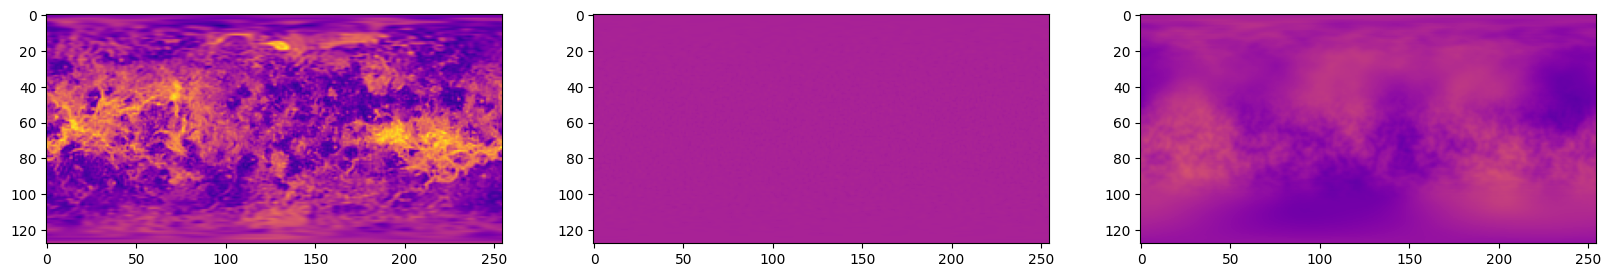

In [15]:
from matplotlib import pyplot as plt 

if reality:
    # Create and store signs 
    msigns = (-1)**jnp.arange(1,L)

    # Reflect and apply hermitian symmetry
    flm_full_end = jnp.zeros((L, 2*L-1), dtype=jnp.complex128)
    flm_full_end = flm_full_end.at[:,L-1:].set(flm)
    flm_full_end = flm_full_end.at[:, : L - 1].set(jnp.flip(jnp.conj(flm_full_end[:, L:])*msigns, axis=-1))

    # Reflect and apply hermitian symmetry
    flm_full_start = jnp.zeros((L, 2*L-1), dtype=jnp.complex128)
    flm_full_start = flm_full_start.at[:,L-1:].set(flm_start)
    flm_full_start = flm_full_start.at[:, : L - 1].set(jnp.flip(jnp.conj(flm_full_start[:, L:])*msigns, axis=-1))

I = s2fft.inverse_jax(Ilm, L, reality=reality)
f_start = s2fft.inverse_jax(flm_full_start, L, reality=reality)
f_end = s2fft.inverse_jax(flm_full_end, L, reality=reality)

mx, mn = np.nanmax(I), np.nanmin(I)
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(I, vmax=mx, vmin=mn, cmap='plasma')
ax2.imshow(f_start, vmax=mx, vmin=mn, cmap='plasma')
ax3.imshow(f_end, vmax=mx, vmin=mn, cmap='plasma')
plt.show()

In [ ]:
s2fft.utils.plotting_functions.plot_sphere(I, L, sampling, isnotebook=True)

In [ ]:
s2fft.utils.plotting_functions.plot_sphere(f_end, L, sampling, isnotebook=True)

In [16]:
def compute_ps(flm):
    return jnp.sum(jnp.abs(flm)**2,axis=-1)

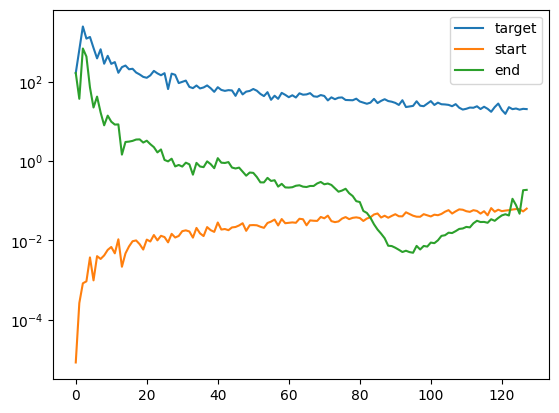

In [17]:
from matplotlib import pyplot as plt 
ps_true = compute_ps(Ilm)
ps_start = compute_ps(flm_start)
ps_end = compute_ps(flm)
plt.plot(ps_true, label="target")
plt.plot(ps_start, label="start")
plt.plot(ps_end, label="end")
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
mean_start, var_start, S1_start, P00_start, C01_start = scat_cov_axi(flm_start, L, N, J_min, sampling, reality, multiresolution, filters=filters)
mean_end, var_end, S1_end, P00_end, C01_end = scat_cov_axi(flm, L, N, J_min, sampling, reality, multiresolution, filters=filters)

print("mean", np.real(mean), np.real(mean_start), np.real(mean_end))
print("var", np.real(var), np.real(var_start), np.real(var_end))

In [ ]:
c = S1.size
for i in range(c):
    print(np.real(S1[i]), np.real(S1_start[i]), np.real(S1_end[i]))

In [ ]:
c = P00.size
for i in range(c):
    print(np.real(P00[i]), np.real(P00_start[i]), np.real(P00_end[i]))

In [ ]:
c = C01.size
for i in range(c):
    print(np.real(C01[i]), np.real(C01_start[i]), np.real(C01_end[i]))

In [ ]:
C01

In [ ]:
C01_end

In [ ]:
C01_start